In [254]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

# Data

In [255]:
training = pd.read_csv('Data/TrainingWiDS2021.csv', index_col=0)

In [256]:
test = pd.read_csv('Data/UnlabeledWiDS2021.csv', index_col=0)

In [257]:
train_is_positive = training['diabetes_mellitus']==1
train_is_negative = ~train_is_positive

# Analysis

## Helpers

In [258]:
def hist_by_diagnosis(feature):
    x = training[feature]
    plt.hist([x[train_is_positive], x[train_is_negative]])
    plt.title(f'Distribution of Diagnosis by {feature}')
    plt.legend(["+", "-"])

## Age

C:\Users\Brian\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Brian\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


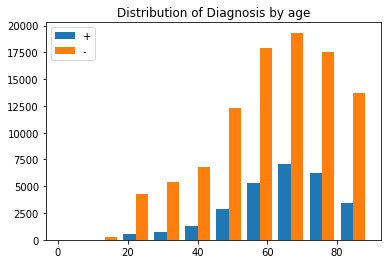

In [259]:
hist_by_diagnosis('age')

# Prediction

## Helpers

In [260]:
import sklearn.linear_model as lm
import sklearn.neighbors as nb
import sklearn.tree as tree
import sklearn.preprocessing as pp

In [261]:
def balance_training():
    has_diabetes = training[train_is_positive].sample(25000)
    no_diabetes = training[train_is_negative].sample(25000)
    return pd.concat([has_diabetes,no_diabetes])

In [262]:
def execute(classifier, features):
    classifier.fit(training[features], training['diabetes_mellitus'])
    test['diabetes_mellitus']=classifier.predict(test[features])
    write_solution(test)
    return classifier

In [263]:
def write_solution(solution):
    results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
    results.to_csv('Data/results.csv')

## Data Preparation

In [264]:
training = balance_training()

In [265]:
training['bmi'] = pd.to_numeric(training['bmi'])
test['bmi'] = pd.to_numeric(test['bmi'])

In [266]:
training['age'] = training['age'].fillna(0)

In [267]:
training['bmi'] = training['bmi'].fillna(0)
test['bmi'] = test['bmi'].fillna(0)

In [268]:
training['glucose_apache'] = training['glucose_apache'].fillna(0)
test['glucose_apache'] = test['glucose_apache'].fillna(0)

In [ ]:
training['ethnicity'] = training['ethnicity'].fillna("Other/Unknown")
test['ethnicity'] = test['ethnicity'].fillna("Other/Unknown")

## Diagnosis = 0

In [269]:
solution = pd.read_csv('Data/SolutionTemplateWiDS2021.csv', index_col=0)

In [270]:
test['diabetes_mellitus'] = 0

In [271]:
write_solution(test)

## Diagnosis = elective_surgery

In [272]:
test['diabetes_mellitus'] = test['elective_surgery']

In [273]:
write_solution(test)

## Age logistic regression

In [274]:
clf = execute(lm.LogisticRegression(), ['age'])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [275]:
X_test = np.linspace(0,100,300)

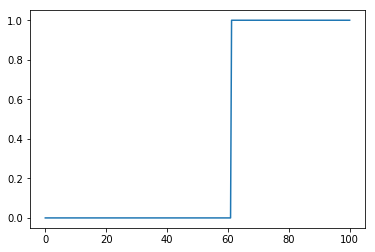

In [276]:
plt.plot(X_test, clf.predict(X_test[:,None]));

## Age + BMI logistic regression

In [277]:
execute(lm.LogisticRegression(), ['age', 'bmi']);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Age + BMI kNN classifier

In [278]:
execute(nb.KNeighborsClassifier(), ['age','bmi']);

## Age, BMI, Glucose Apache kNN

In [279]:
execute(nb.KNeighborsClassifier(), ['age','bmi','glucose_apache']);

## Age, BMI, Glucose Apache logistic regression

In [280]:
execute(lm.LogisticRegression(), ['age','bmi','glucose_apache']);

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Decision Tree

In [281]:
execute(tree.DecisionTreeClassifier(), ['age','bmi','glucose_apache']);

# Miscellaneous

In [301]:
## TODO: encode test set; drop original column
def encode(column):
    global training
    encoder = pp.OneHotEncoder()
    encodings = encoder.fit_transform(training[[column]]).toarray()
    columns = [column + ": " + category for category in encoder.categories_[0]]
    encodings_df = pd.DataFrame(encodings, columns=columns, index=training.index)
    training = training.join(encodings_df)
encode("ethnicity")

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,ethnicity: African American,ethnicity: Asian,ethnicity: Caucasian,ethnicity: Hispanic,ethnicity: Native American,ethnicity: Other/Unknown
77363,266887,103,44.0,0.000000,0,Other/Unknown,F,NaN,Emergency Department,Accident & Emergency,...,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0
129401,248471,7,73.0,31.146808,0,African American,M,165.10,Step-Down Unit (SDU),Floor,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
51439,234428,133,71.0,37.407201,0,Hispanic,F,162.60,Floor,Floor,...,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0
93743,237254,73,63.0,67.814990,0,Caucasian,M,172.70,NaN,Other Hospital,...,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0
23764,259706,161,40.0,36.328125,0,Other/Unknown,F,160.00,Acute Care/Floor,Floor,...,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0
84597,241594,188,68.0,46.958674,0,Hispanic,M,165.10,Direct Admit,Accident & Emergency,...,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0
43473,219118,186,61.0,46.591809,0,Caucasian,F,165.10,Emergency Department,Accident & Emergency,...,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0
127841,155783,7,58.0,21.937489,1,African American,M,162.60,Operating Room,Operating Room / Recovery,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
88399,149323,146,62.0,29.833426,0,African American,M,182.90,NaN,Floor,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0
51355,234328,26,72.0,15.825496,0,Asian,M,172.70,Emergency Department,Accident & Emergency,...,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0


In [206]:
ethnicity_columns = [col for col in training.columns if "ethnicity" in col[0]]
ethnicity_columns
#training[ethnicity_columns]
execute(tree.DecisionTreeClassifier(), ethnicity_columns);

KeyError: "[('ethnicity: African American',) ('ethnicity: Asian',)\n ('ethnicity: Caucasian',) ('ethnicity: Hispanic',)\n ('ethnicity: Native American',) ('ethnicity: Other/Unknown',)] not in index"

In [131]:
training['ethnicity']

90815       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
60627       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
120335      (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
55740       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
80132       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
126977      (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
119708      (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
129117      (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
93127       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
57935       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
28454       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
100353      (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
65778       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
24018       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
110034      (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
81624       (0, 2)\t1.0\n  (1, 2)\t1.0\n  (2, 0)\t1.0\n ...
119904      (0, 2)\t1.0\n  (1, 2)\t1.0\n

In [128]:
execute(tree.DecisionTreeClassifier(), ['ethnicity'])

ValueError: setting an array element with a sequence.